In [69]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn import tree
import numpy as np
import subprocess
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# BVU Students Retention model

## Goals

1. Find factors influencing whether the first year student of Buena Vista University will be back to the school or not; 
2. Build and analyze model(s) to predict if a student is coming back to the school after their first year;

## Key Questions

* Which features have the most predicting power;
* Which assumptions;
* Which ML model to use;

In [70]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('first_year_students.csv')
df.index = df['Research ID']
df.drop('Research ID', axis = 1, inplace = True)
df.head()

,Race,International,Sex,Miles,Commuter,Dorm,IowaResident,SchoolofMajor,Athlete,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,BVGPA,Hrs,Returned
Research ID,,,,,,,,,,,,,,,,,
1,E,0,0,70-79,0.0,A,1,I,1,NaN,30.0,30.0,26.0,2.66,0.000,13.0,0
2,E,0,1,250-274,0.0,C,0,H,2,0.341,18.0,17.0,13.0,3.57,3.000,12.0,0
3,B,1,1,NaN,0.0,F,0,I,1,NaN,NaN,NaN,NaN,NaN,1.466,15.0,0
4,B,1,1,NaN,0.0,D,0,K,1,NaN,NaN,NaN,NaN,NaN,3.428,14.0,0
5,B,1,1,NaN,0.0,D,0,K,1,NaN,NaN,NaN,NaN,NaN,3.000,14.0,0


## Fields

* Race -- letter abbreviation of the race
* International -- int, 1 -- international student
* Sex -- int, indicator of students' gender
* Miles -- categorical, distance from home
* Commuter -- int, 1 -- commuter
* Dorm -- categorical, indicates the dorm code
* IowaResident -- int, 1 -- resident of Iowa
* SchoolofMajor -- categorical, code for the school of major
* Athlete -- int, athlete status
* HSRank -- float, rank at High School
* ACTXxxx -- ACT scores:
    * ACTComp -- float, ACT Comp score
    * ACTMath -- float, ACT Math score
    * ACTEng -- float, ACT English score
* HSGPA -- float, High School GPA score
* BVGPA -- float, Buena Vista University GPA score
* Hrs -- float, credit hours taken last semester
* Returned -- int, target variable -- student returned (1) or not (0)

## Exploratory Analysis

### How much missing data are there?

* **No missing data**: Race, International, Sex, IowaResident, SchoolofMajor, Athlete, and Returned (target);
* **Minor missing data**: Commuter -- one record is missing, Hrs -- 11 values are missing;
* **Major missing data**: Miles, Dorm; HSRank, 
    * ACTComp, ACTMath, ACTEng -- not all students have taken the ACT tests; The presence/absence of these scores may be an indication of students' performance at their high school;
    * HSGPA, BVGPA -- High school GPA -- reason missing unknown, possibly not all schools compute GPA, possibly relates to international status. BV GPA -- this may be fixable via university;


In [71]:
df.isna().sum()

Race               0
International      0
Sex                0
Miles             44
Commuter           1
Dorm             109
IowaResident       0
SchoolofMajor      0
Athlete            0
HSRank           111
ACTComp           86
ACTMath          117
ACTEng           118
HSGPA             63
BVGPA             62
Hrs               11
Returned           0
dtype: int64

## Target variable: how many students returned?

The dataset is out of balance -- ~73\% students returned after their first year

In [72]:
print("Returned: %.4f"%df.Returned.mean())

Returned: 0.7272


## Exploring factors

### Miles from home

This may or may not be a predictive factor. Below is a statistical analysis of factor significance.

#### Hypothesis testing: 

Ha: Miles from home has an effect on retention;

H0: Miles has no effect on retention;

In [73]:
df_miles = df[['Miles','Returned']].dropna().copy() # remove missing miles from home
df_miles['from_miles'] = df_miles['Miles'].apply( # extract 'from_miles' from the range
    lambda x:str(x).split('-')[0] if len(str(x).split('-')) > 0 else 0).astype(int)
df_miles.head()

,Miles,Returned,from_miles
Research ID,,,
1,70-79,0,70
2,250-274,0,250
93,350-399,1,350
94,100-109,1,100
95,70-79,1,70


Check f_classif function to estimate the significance of the factor. p_value is low (0.0008), this is an indication that the H0 can be rejected:

In [74]:
from sklearn.feature_selection import f_classif

p_value = f_classif(df_miles[['from_miles']],df_miles.Returned)[1]
print("p_value: %.4f"%p_value)

p_value: 0.0008


Another test: applying linear regression and testing the p-value of the coefficient. p_value is 0.00077 (as before), the H0 can be rejected. 

In [75]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_miles.from_miles,df_miles.Returned)
slope, intercept, r_value, p_value, std_err

(-2.1004367727474384e-05,
 0.7348247947502577,
 -0.055651181315432154,
 0.0007718090738908786,
 6.2409877898337994e-06)

p-value < 0.05, H0 -- rejected.

#### Miles from home: dealing with the missing values

In [76]:
df_miles = df[['Miles','Returned']].copy()
print('Return rate, where miles are missing: %.4f'%df_miles[df_miles.Miles.isna()]['Returned'].mean())
print('Return rate, where miles are present: %.4f'%df_miles[~df_miles.Miles.isna()]['Returned'].mean())

Return rate, where miles are missing: 0.5227
Return rate, where miles are present: 0.7297


The absence/presence of miles from home has a predictive power, so add a new feature: 'miles_missing'

In [77]:
df['miles_missing'] = df['Miles'].isna().astype(int)
df.miles_missing.head()

Research ID
1    0
2    0
3    1
4    1
5    1
Name: miles_missing, dtype: int64

#### Miles from home
Convert the categorical value to a number. We expect the distribution to be right-skewed, so let us add a new feature 'log_mean_miles' as well:

In [78]:
df['mean_miles'] = df.loc[df.miles_missing == 0,'Miles'].apply(lambda x:sum([int(m) for m in str(x).split('-')])/2)
df['log_mean_miles'] = np.log(df.mean_miles)
df[['Miles','mean_miles','log_mean_miles','miles_missing']].head()

,Miles,mean_miles,log_mean_miles,miles_missing
Research ID,,,,
1,70-79,74.5,4.310799,0
2,250-274,262.0,5.568345,0
3,NaN,NaN,NaN,1
4,NaN,NaN,NaN,1
5,NaN,NaN,NaN,1


In [79]:
# Set missing numerical miles to 0
# TODO: change to mean value for the column
df.loc[df.miles_missing == 1, ['mean_miles','log_mean_miles']] = 0

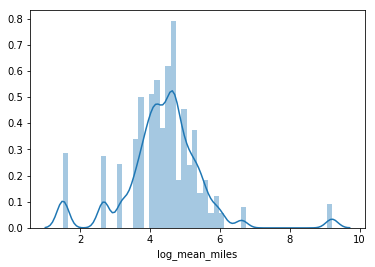

In [80]:
# The distribution of log_mean_miles is not skewed:
sns.distplot(df[df.miles_missing == 0].log_mean_miles)

In summary, for miles from home, the following features have been created:

* missing_miles -- boolean, y/n the value is missing;
* mean_miles -- average miles from home;
* log_mean_miles -- natural logarithm of average miles from home;

### Race, International, and Sex

First, explore the features and their (potential) effect on the target variable. Races E, J, and B tend to have lower return rate as compared to A, G, and I:

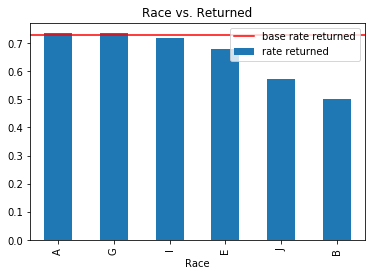

In [81]:
plt.figure()
ax = plt.subplot(1,1,1)
df.groupby('Race')['Returned'].mean().sort_values(ascending = False).plot(ax = ax,
    kind = 'bar', title = 'Race vs. Returned', label = 'rate returned')
ax.axhline(y = df.Returned.mean(), label = 'base rate returned', color = 'r')
plt.legend()
plt.show()

Non-international students have higher return rate as compared to internationals:

In [82]:
# Checking international
df.groupby('International')['Returned'].mean()

International
0    0.729863
1    0.500000
Name: Returned, dtype: float64

Students of sex '0' have higher return rate as compared to those of sex '1': 

In [83]:
# Checking sex
df.groupby('Sex')['Returned'].mean()

Sex
0    0.747976
1    0.706362
Name: Returned, dtype: float64

In summary, it appears that all three features may have predictive power.

For further analysis, convert the *Race* into one-hot-encoding and test all features with ANOVA, Ridge regression, and LASSO:

In [84]:
df_personal = df[['Race','International','Sex']]
df_personal = pd.get_dummies(df_personal) # get one-hot-encoding

In [85]:
from sklearn.feature_selection import f_regression
F,p = f_regression(df_personal,df.Returned)
sorted(list(zip(p,df_personal.columns)), key = lambda x:x[0])

[(0.0008776242068933963, 'International'),
 (0.0008776242068933963, 'Race_B'),
 (0.0019123090548312524, 'Race_J'),
 (0.0021267069564537707, 'Race_A'),
 (0.00452201504648262, 'Sex'),
 (0.2219381942341431, 'Race_E'),
 (0.8185268791020879, 'Race_I'),
 (0.8602458629254127, 'Race_G')]

According to p-values, International, Sex, Race_B, Race_J, and Race_A are significant. The figure above suggests that Race_E may also have an effect. We will include it into the model:

In [86]:
df['Race_B'] = df_personal.Race_B
df['Race_J'] = df_personal.Race_J
df['Race_A'] = df_personal.Race_A
df['Race_E'] = df_personal.Race_E

In [87]:
df.head()

,Race,International,Sex,Miles,Commuter,Dorm,IowaResident,SchoolofMajor,Athlete,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,BVGPA,Hrs,Returned,miles_missing,mean_miles,log_mean_miles,Race_B,Race_J,Race_A,Race_E
Research ID,,,,,,,,,,,,,,,,,,,,,,,,
1,E,0,0,70-79,0.0,A,1,I,1,NaN,30.0,30.0,26.0,2.66,0.000,13.0,0,0,74.5,4.310799,0,0,0,1
2,E,0,1,250-274,0.0,C,0,H,2,0.341,18.0,17.0,13.0,3.57,3.000,12.0,0,0,262.0,5.568345,0,0,0,1
3,B,1,1,NaN,0.0,F,0,I,1,NaN,NaN,NaN,NaN,NaN,1.466,15.0,0,1,0.0,0.000000,1,0,0,0
4,B,1,1,NaN,0.0,D,0,K,1,NaN,NaN,NaN,NaN,NaN,3.428,14.0,0,1,0.0,0.000000,1,0,0,0
5,B,1,1,NaN,0.0,D,0,K,1,NaN,NaN,NaN,NaN,NaN,3.000,14.0,0,1,0.0,0.000000,1,0,0,0


### Iowa resident and Commuter fields

Students who are Iowa residents have a higher return rate (74%) vs. those who are not (68%):

In [88]:
df.groupby('IowaResident')['Returned'].mean()

IowaResident
0    0.675029
1    0.743517
Name: Returned, dtype: float64

Those that have to commute to the school have a significantly lower return rate. Buena Vista University is a residential campus, where only several groups of students are approved to live off-campus, such as those that have family, etc. This factor may be an indirect indication of the family situation.

In [89]:
df.groupby('Commuter')['Returned'].mean()

Commuter
0.0    0.731422
1.0    0.581633
Name: Returned, dtype: float64

In [90]:
# Commuter has a single value missing. fill it with the mode 0:
df.Commuter.mode()
df.Commuter.fillna(0, inplace = True)

### BV GPA

Buena Vista University's GPA after the first semester appears to be another strong predictor. The students who perform well will more likely stay at the university as demonstrated at the graph below. The histogram of GPA's for those that did not come back is almost uniform, suggesting that factors other than BV GPA had affected their decision.

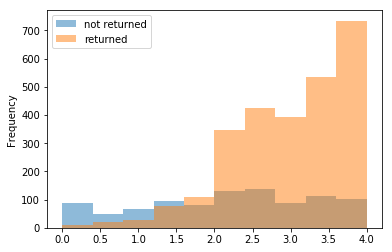

In [91]:
df.loc[df.Returned == 0, 'BVGPA'].plot(kind = 'hist', alpha = 0.5, label = 'not returned')
df.loc[df.Returned == 1, 'BVGPA'].plot(kind = 'hist', alpha = 0.5, label = 'returned')
plt.legend()
plt.show()

We will include BV GPA to the model and temporarily replace the missing values with BV GPA mean score. This may need revisiting in the future for other (better) options.

In [92]:
# Fill in the missing values with mean's
# TODO: explore other options here
df['BVGPA'].fillna(df.BVGPA.mean(), inplace = True)

## Hours taken

How many hours the student has taken at BVU demonstrates students' commitment to study and may also be a proxy for other factors, such as family situation (unable to take the regular amount of hours due to other factors).

However, the histogram reveals several abnormally high and low hours recorded:

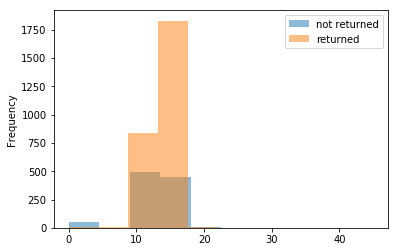

In [93]:
df.loc[df.Returned == 0, 'Hrs'].plot(kind = 'hist', alpha = 0.5, label = 'not returned')
df.loc[df.Returned == 1, 'Hrs'].plot(kind = 'hist', alpha = 0.5, label = 'returned')
plt.legend()
plt.show()

A typical student load per semester is up to 24 credit hours (8 classes). However, 4 student records show hours from 26.5 to 44. It looks like these were incorrectly entered as the **sum** of hours for the two semesters vs. **average** hours. This seems plausible, so these hours will be divide by 2. The smallest (26.5) value, when divided by 2 ~13 is still above the minimum hours required (12) for a full time student.

In [94]:
# Abnormally high number of credit hours over 8 classes per semester:
df[df.Hrs > 25]

,Race,International,Sex,Miles,Commuter,Dorm,IowaResident,SchoolofMajor,Athlete,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,BVGPA,Hrs,Returned,miles_missing,mean_miles,log_mean_miles,Race_B,Race_J,Race_A,Race_E
Research ID,,,,,,,,,,,,,,,,,,,,,,,,
1891,A,0,0,60-69,0.0,A,1,J,1,0.157,28.0,26.0,29.0,3.60,3.681,44.0,1,0,64.5,4.166665,0,0,1,0
2328,G,0,0,50-59,0.0,A,1,H,1,0.300,21.0,22.0,19.0,3.12,3.845,45.0,0,0,54.5,3.998201,0,0,0,0
3505,A,0,0,20-29,0.0,D,1,H,1,0.136,26.0,28.0,25.0,3.87,3.909,33.0,0,0,24.5,3.198673,0,0,1,0
4065,A,0,0,200-224,0.0,C,1,G,1,0.708,21.0,17.0,21.0,3.27,2.075,26.5,0,0,212.0,5.356586,0,0,1,0


In [95]:
df['hours_corrected'] = df.Hrs
df['hours_corrected'] = df.hours_corrected.apply(lambda x:x if x < 25 else x/2)

In [96]:
# fill in the missing values with means
df.hours_corrected.fillna(df.hours_corrected.mean(), inplace = True)

## Athlete status

Buena Vista University has many athletes and it may be an important factor for future or current students. The analysis below shows difference in the return rate based on athlete status (1 or 2). Let us also check if it is statistically significant or not. 

In [97]:
df.groupby('Athlete')['Returned'].mean()

Athlete
1    0.716964
2    0.743113
Name: Returned, dtype: float64

In [98]:
p_value = f_classif(df[['Athlete']],df_miles.Returned)[1]
print("p_value: %.4f"%p_value)

p_value: 0.0814


The athlete status fails the hypothesis testing. The p-value is high (0.08), we **fail to reject the null hypothesis**. We will exclude athlete status from our analysis for now. 

## Academic scores

Academic scores are likely strong predictors of the target variable. However, they have multiple values missing. As previously mentioned, the values are **not missing randomly** and it may be an indication of students' decision not to take the test or the school not administering the tests. 

In [99]:
df[['HSRank','ACTComp','ACTMath','ACTEng','HSGPA']].isna().sum()

HSRank     111
ACTComp     86
ACTMath    117
ACTEng     118
HSGPA       63
dtype: int64

In [100]:
df[['HSRank','ACTComp','ACTMath','ACTEng','HSGPA']].mean()

HSRank      0.336527
ACTComp    22.318913
ACTMath    21.914126
ACTEng     21.535255
HSGPA       3.324877
dtype: float64

Check statistical significance of the fields. All fields have low p-values:

In [101]:
df_scores = df[['HSRank','ACTComp','ACTMath','ACTEng','HSGPA','Returned']].copy().dropna()
p_value = f_classif(df_scores.drop('Returned', axis = 1),df_scores.Returned)[1]
list(zip(['HSRank','ACTComp','ACTMath','ACTEng','HSGPA'],p_value))

[('HSRank', 2.282557604056117e-51),
 ('ACTComp', 2.0444738245814064e-24),
 ('ACTMath', 1.8478960192592148e-25),
 ('ACTEng', 6.005565451998721e-17),
 ('HSGPA', 6.573772927791943e-54)]

#### Is absence of scores statistically significant?

In [102]:
df_scores = df[['HSRank','ACTComp','ACTMath','ACTEng','HSGPA','Returned']].copy()
df_scores_present = df_scores.isna().copy().astype(int)
df_scores_present['Returned'] = df_scores['Returned']
df_scores_present.head()

,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,Returned
Research ID,,,,,,
1,1,0,0,0,0,0
2,0,0,0,0,0,0
3,1,1,1,1,1,0
4,1,1,1,1,1,0
5,1,1,1,1,1,0


In [103]:
p_value = f_classif(df_scores_present.drop('Returned', axis = 1),df_scores_present.Returned)[1]
list(zip(['HSRank','ACTComp','ACTMath','ACTEng','HSGPA'],p_value))

[('HSRank', 0.002971645133557204),
 ('ACTComp', 0.01938359332744131),
 ('ACTMath', 0.00031019288776900565),
 ('ACTEng', 0.00040875100270391625),
 ('HSGPA', 0.011874775661496794)]

All features listed above are statistically significant as well as presence/absence of high school rank & GPA, and ACT scores. We will include presence/absence to our model and fill the missing academic score values with their means. 

In [104]:
for c in df_scores_present.drop('Returned', axis = 1).columns:
    col_name = c+'_present'
    df[col_name] = df_scores_present[c]
    
for c in ['HSRank','ACTComp','ACTMath','ACTEng','HSGPA']:
    mean_score = df[c].mean()
    df[c].fillna(mean_score, inplace = True)
df.head()

,Race,International,Sex,Miles,Commuter,Dorm,IowaResident,SchoolofMajor,Athlete,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,BVGPA,Hrs,Returned,miles_missing,mean_miles,log_mean_miles,Race_B,Race_J,Race_A,Race_E,hours_corrected,HSRank_present,ACTComp_present,ACTMath_present,ACTEng_present,HSGPA_present
Research ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,E,0,0,70-79,0.0,A,1,I,1,0.336527,30.000000,30.000000,26.000000,2.660000,0.000,13.0,0,0,74.5,4.310799,0,0,0,1,13.0,1,0,0,0,0
2,E,0,1,250-274,0.0,C,0,H,2,0.341000,18.000000,17.000000,13.000000,3.570000,3.000,12.0,0,0,262.0,5.568345,0,0,0,1,12.0,0,0,0,0,0
3,B,1,1,NaN,0.0,F,0,I,1,0.336527,22.318913,21.914126,21.535255,3.324877,1.466,15.0,0,1,0.0,0.000000,1,0,0,0,15.0,1,1,1,1,1
4,B,1,1,NaN,0.0,D,0,K,1,0.336527,22.318913,21.914126,21.535255,3.324877,3.428,14.0,0,1,0.0,0.000000,1,0,0,0,14.0,1,1,1,1,1
5,B,1,1,NaN,0.0,D,0,K,1,0.336527,22.318913,21.914126,21.535255,3.324877,3.000,14.0,0,1,0.0,0.000000,1,0,0,0,14.0,1,1,1,1,1


### School of Major and Dorm

Here we study the potential effect(s) of Schoolf Major and Dorm on the return rates. While school of major does not have any missing values, Dorm has ~107 of those. The fact that the data is missing may or may not be random, we will impute 'U' for unknown dorm:

In [263]:
df_school = df[['SchoolofMajor','Dorm']].copy()
df_school['Dorm'].fillna('U', inplace = True) # impute 'U' for unknown dorm
df_school = pd.get_dummies(df_school[['SchoolofMajor','Dorm']])

In [264]:
sorted(list(zip(df_school.columns,f_classif(df_school,df.Returned)[1])), key = lambda x:x[1])

[('Dorm_U', 3.3413112e-06),
 ('Dorm_B', 6.684442e-05),
 ('Dorm_E', 0.00019486317),
 ('SchoolofMajor_K', 0.0019382931),
 ('Dorm_A', 0.0043622716),
 ('SchoolofMajor_G', 0.07861868),
 ('Dorm_F', 0.10249952),
 ('SchoolofMajor_I', 0.15697381),
 ('Dorm_D', 0.27927324),
 ('SchoolofMajor_F', 0.35182652),
 ('SchoolofMajor_J', 0.60936564),
 ('Dorm_C', 0.9622182),
 ('SchoolofMajor_H', 0.96904784)]

It appears that dorms B, E, A, and U (unknown); as well as School of Major 'K' have an effect on return rate. We will include these fields to the model:

In [265]:
for f, p in sorted(list(zip(df_school.columns,f_classif(df_school,df.Returned)[1])), key = lambda x:x[1]):
    if p < 0.05:
        df[f] = df_school[f]

In [266]:
df.head()

,Race,International,Sex,Miles,Commuter,Dorm,IowaResident,SchoolofMajor,Athlete,HSRank,ACTComp,ACTMath,ACTEng,HSGPA,BVGPA,Hrs,Returned,miles_missing,mean_miles,log_mean_miles,Race_B,Race_J,Race_A,Race_E,hours_corrected,HSRank_present,ACTComp_present,ACTMath_present,ACTEng_present,HSGPA_present,Dorm_U,Dorm_B,Dorm_E,SchoolofMajor_K,Dorm_A
Research ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,E,0,0,70-79,0.0,A,1,I,1,0.336527,30.000000,30.000000,26.000000,2.660000,0.000,13.0,0,0,74.5,4.310799,0,0,0,1,13.0,1,0,0,0,0,0,0,0,0,1
2,E,0,1,250-274,0.0,C,0,H,2,0.341000,18.000000,17.000000,13.000000,3.570000,3.000,12.0,0,0,262.0,5.568345,0,0,0,1,12.0,0,0,0,0,0,0,0,0,0,0
3,B,1,1,NaN,0.0,F,0,I,1,0.336527,22.318913,21.914126,21.535255,3.324877,1.466,15.0,0,1,0.0,0.000000,1,0,0,0,15.0,1,1,1,1,1,0,0,0,0,0
4,B,1,1,NaN,0.0,D,0,K,1,0.336527,22.318913,21.914126,21.535255,3.324877,3.428,14.0,0,1,0.0,0.000000,1,0,0,0,14.0,1,1,1,1,1,0,0,0,1,0
5,B,1,1,NaN,0.0,D,0,K,1,0.336527,22.318913,21.914126,21.535255,3.324877,3.000,14.0,0,1,0.0,0.000000,1,0,0,0,14.0,1,1,1,1,1,0,0,0,1,0


## Summary of features selected

* miles_missing, mean_miles, log_mean_miles;
* hours_corrected;
* International, Sex, Commuter, IowaResident;
* Race_B, Race_J, Race_A, Race_E;
* HSRank_present, HSGPA_present, ACTXXX_present;
* BVGPA, HSGPA, HSRank, ACTXXX;
* Dorms U (unknown), B, E, and A;
* School of Major == K;

Let us create the subset of features and split it into training/test:

In [316]:
from sklearn.model_selection import train_test_split

X = df[['miles_missing','mean_miles','log_mean_miles',
        'hours_corrected',
        'International','Sex','Commuter','IowaResident',
        'Race_B','Race_J','Race_A','Race_E',
        'HSRank_present','ACTComp_present','ACTMath_present','ACTEng_present','HSGPA_present',
       'BVGPA','HSGPA','HSRank','ACTComp','ACTMath','ACTEng',
        'Dorm_U','Dorm_B','Dorm_E','Dorm_A','SchoolofMajor_K'
       ]]
y = df['Returned']
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1) # fix random_state for repeatability
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2769, 28), (923, 28), (2769,), (923,))

## Visualizing the data

Here we look into the data to see how separable are the two classes (returned/not-returned). The process is two-fold:

1. Normalize the data, convert all features to their Z-scores: $X_{norm} = \frac{X-\mu_X}{\sigma_X}$;
1. Apply PCA and see how many components are needed to keep 95% of variance in the data;
2. Apply t-SNE algorithm to convert to two features and visualize;

In [317]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X_train)
X_train_norm = ss.transform(X_train)
X_test_norm = ss.transform(X_test)

In [318]:
from sklearn.decomposition import PCA
pc = PCA().fit(X_train_norm)
n_comps = np.argmax(np.cumsum(pc.explained_variance_ratio_) > 0.95)
print("%d components preserve 95%% of variance"%n_comps)

17 components preserve 95% of variance


Apply PCA, t-SNE, and visualize:

In [319]:
pc = PCA(n_components=n_comps,random_state=1)
X_train_pca = pc.fit_transform(X_train_norm)
X_test_pca = pc.transform(X_test_norm)

In [320]:
from sklearn.manifold import TSNE
X_train_vis = TSNE(n_components=2, random_state = 1, perplexity = 25).fit_transform(X_train_pca)

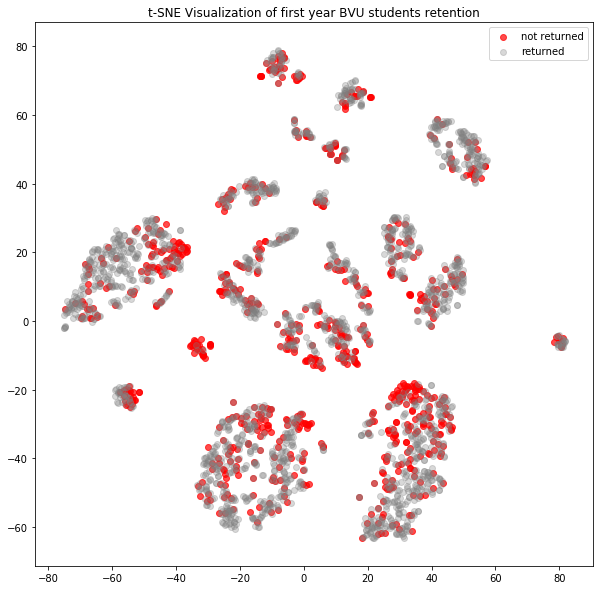

In [321]:
plt.figure(figsize = (10,10))
for idx, label_ in enumerate([('r',0.7,'not returned'),('gray',0.3,'returned')]):
    plt.scatter(X_train_vis[y_train == idx][:,0],
                X_train_vis[y_train == idx][:,1], alpha = label_[1],
                label = label_[2], color = label_[0])
plt.title('t-SNE Visualization of first year BVU students retention')
plt.legend()
plt.show()

It does not seem easy to separate the two classes. Perhaps some important features are still missing from the analysis. 

# Modeling

## Balancing the data

The data is highly unbalanced, i.e. there are ~72% students who returned, vs. 28% who did not. The data need to be balanced before proceeding. SMOTE algorithm will create synthetic data points where returned = 0.

In [322]:
print("Ratio of returned students to all: %.2f"%np.mean(y_train == 1))

Ratio of returned students to all: 0.72


In [323]:
from imblearn.over_sampling import SMOTE

X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_norm, y_train)

## Logistic Regression

Logistic regression is the simplest interpretable model:

In [392]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'lbfgs',
                        #class_weight = {0:2,1:1}
                        C = 0.9,
                        verbose = 1
                       ).fit(X_train_smote,y_train_smote)
y_hat = lr.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Performance on unseen (test) data:

In [393]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
cr = classification_report(y_test, y_hat)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       243
           1       0.74      1.00      0.85       680

    accuracy                           0.74       923
   macro avg       0.37      0.50      0.42       923
weighted avg       0.54      0.74      0.63       923



/home/abezuglov/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abezuglov/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/abezuglov/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [402]:
confusion_matrix(y_test, y_hat)

array([[  0, 243],
       [  0, 680]])

## Gaussian Naive Bayes

In [406]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(random_state = 1).fit(X_train_smote,y_train_smote)
confusion_matrix(y_test, gnb.predict(X_test))

array([[218,  25],
       [630,  50]])

In [408]:
cr = classification_report(y_test, gnb.predict(X_test))
print(cr)

              precision    recall  f1-score   support

           0       0.26      0.90      0.40       243
           1       0.67      0.07      0.13       680

    accuracy                           0.29       923
   macro avg       0.46      0.49      0.27       923
weighted avg       0.56      0.29      0.20       923



## Multilayer Perceptron for Classification

In [490]:
from sklearn.neural_network import MLPClassifier

ann = MLPClassifier(random_state = 1, verbose = 0, hidden_layer_sizes=(50,10),
                   max_iter=1000).fit(X_train_smote,y_train_smote)
confusion_matrix(y_test, ann.predict(X_test))

array([[100, 143],
       [201, 479]])

## Gradient Boosting

In [395]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0,
).fit(X_train_smote,y_train_smote)
#gbc.score(df_pva_test_norm, df_pva_test_target)

Performance on training data:

In [396]:
confusion_matrix(y_train_smote, gbc.predict(X_train_smote))

array([[1689,  316],
       [ 103, 1902]])

Performance on unseen data:

In [397]:
confusion_matrix(y_test, gbc.predict(X_test))

array([[143, 100],
       [283, 397]])

In [398]:
cr = classification_report(y_test, gbc.predict(X_test))
print(cr)

              precision    recall  f1-score   support

           0       0.34      0.59      0.43       243
           1       0.80      0.58      0.67       680

    accuracy                           0.59       923
   macro avg       0.57      0.59      0.55       923
weighted avg       0.68      0.59      0.61       923



## AdaBoostClassifier

In [399]:
from sklearn.ensemble import AdaBoostClassifier

In [400]:
ada = AdaBoostClassifier(
    n_estimators = 100, learning_rate=1.0, random_state=0
).fit(X_train_smote,y_train_smote)

Performance on training data:

In [401]:
confusion_matrix(y_train_smote, ada.predict(X_train_smote))

array([[1506,  499],
       [ 292, 1713]])

Performance on test data:

In [391]:
confusion_matrix(y_test, ada.predict(X_test))

array([[  0, 243],
       [  1, 679]])

## Decision tree classifier

In [434]:
dt = DecisionTreeClassifier(max_depth = 5, random_state = 1)
dt.fit(X_train_smote, y_train_smote)

confusion_matrix(y_test, dt.predict(X_test))

array([[  0, 243],
       [  0, 680]])

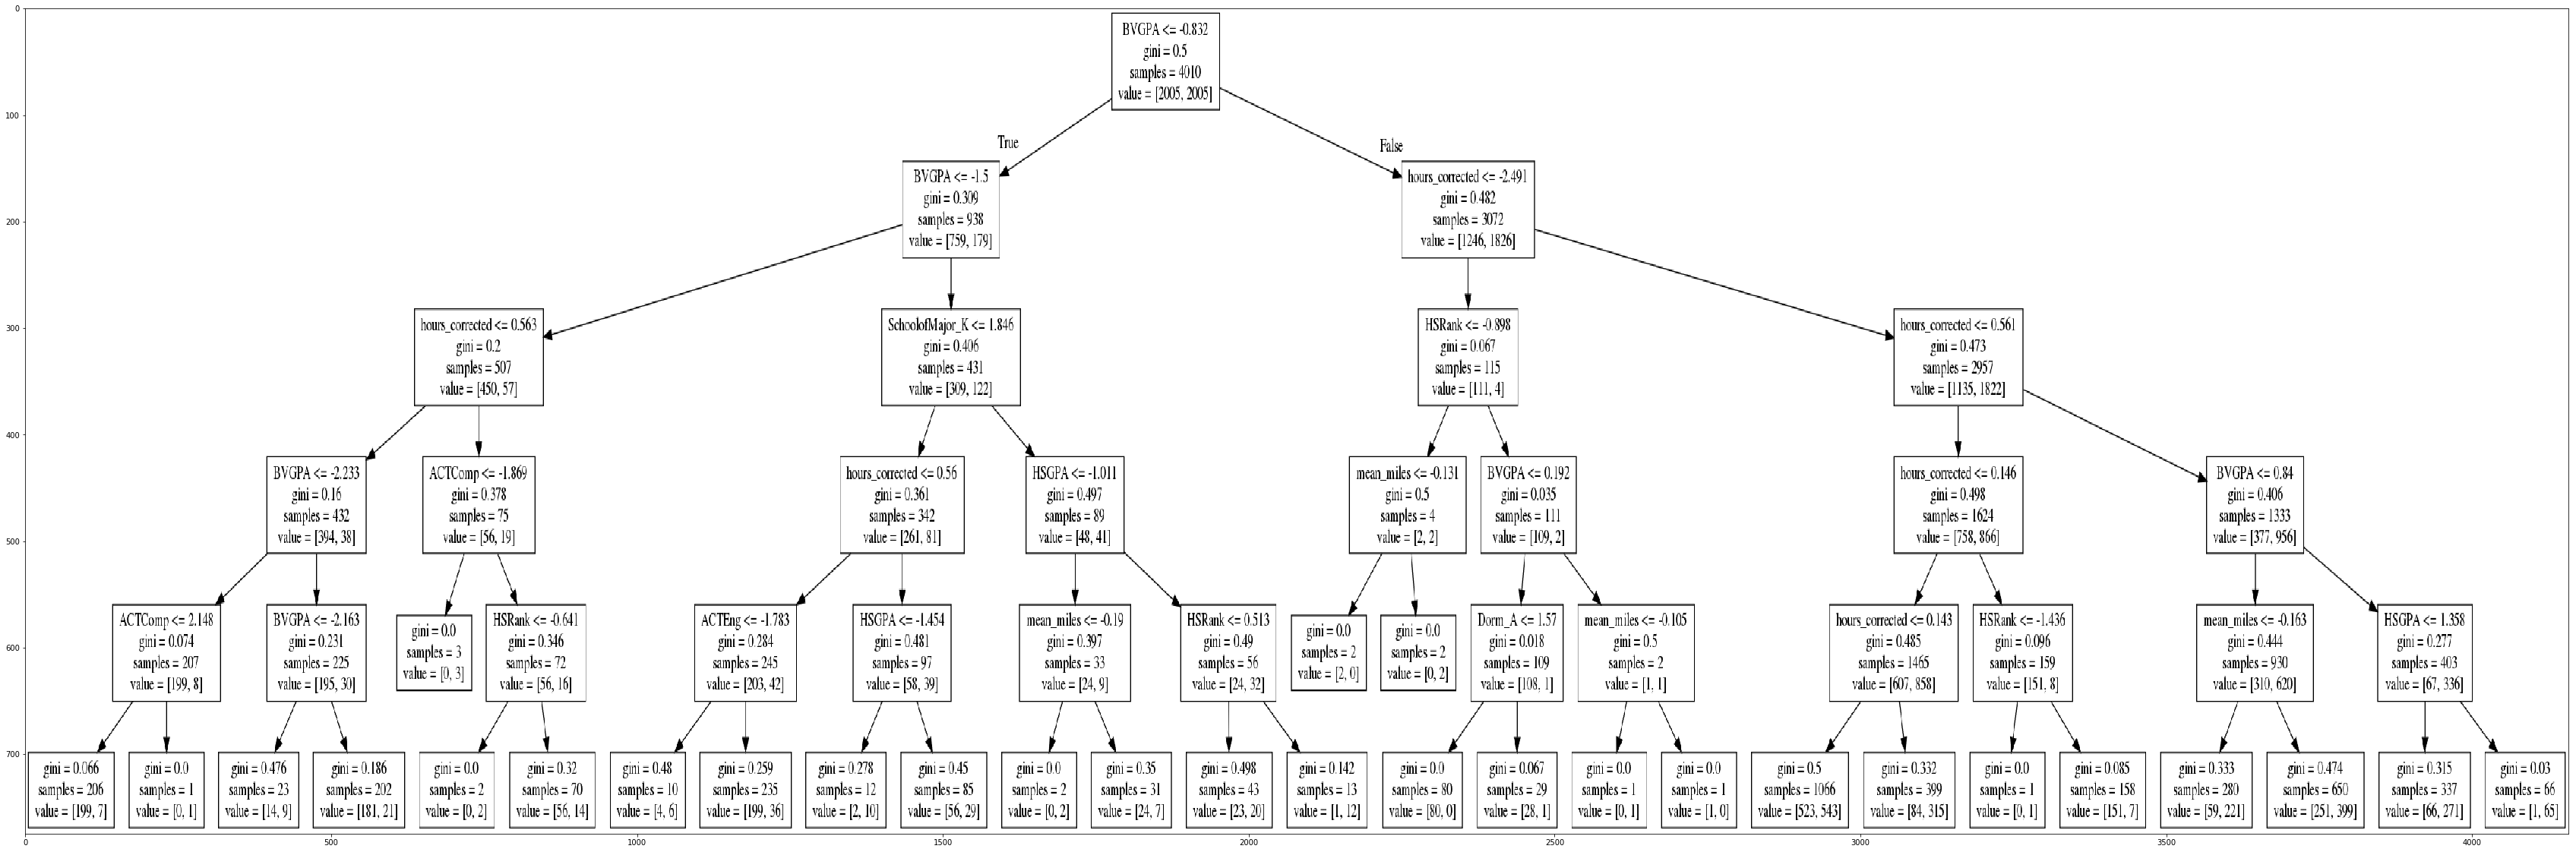

In [435]:
tree.export_graphviz(dt, out_file = 'tree.dot', feature_names = feature_names)
subprocess.call(['dot','-Tpng','tree.dot','-o','tree.png'])
img = mpimg.imread('tree.png')
plt.figure(figsize=(60,20))
imgplot = plt.imshow(img, aspect='auto')
plt.show()

## SVM

In [436]:
sv = SVC(kernel='sigmoid', gamma = 'auto', random_state = 1)
sv.fit(X_train_smote, y_train_smote)
confusion_matrix(y_test, sv.predict(X_test))

array([[222,  21],
       [649,  31]])

## KNN

In [437]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_smote,y_train_smote)
confusion_matrix(y_test, knn.predict(X_test))

array([[ 24, 219],
       [ 55, 625]])

## Selected Models

Based on experimentations above, we select the following models for further study:

In [442]:
models = [('Naive Bayes',GaussianNB()),
('Artificial Neural Network',MLPClassifier(random_state = 1, verbose = 0, hidden_layer_sizes=(50,10),max_iter=1000)),
('Gradient Boosting',GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)),
('Support Vector machine',SVC(kernel='sigmoid', gamma = 'auto', random_state = 1)),
('KNN(5)',KNeighborsClassifier(n_neighbors=5))]

In [444]:
from sklearn.metrics import f1_score
f1_scores = []
for desc,m in models:
    m.fit(X_train_smote,y_train_smote)
    f1_scores.append((desc,f1_score(y_test,m.predict(X_test))))

The best models according to their F1 scores:

In [447]:
sorted(f1_scores, key = lambda x:-x[1])

[('KNN(5)', 0.8202099737532808),
 ('Artificial Neural Network', 0.7357910906298003),
 ('Gradient Boosting', 0.6745964316057773),
 ('Naive Bayes', 0.13245033112582782),
 ('Support Vector machine', 0.08469945355191257)]

The best models according to their recall of non-returned students:

In [453]:
from sklearn.metrics import recall_score
recall_scores = []
for desc,m in models:
    m.fit(X_train_smote,y_train_smote)
    recall_scores.append((desc,recall_score(y_test, m.predict(X_test),labels=['non-returned','returned'], pos_label = 0)))

In [455]:
sorted(recall_scores, key = lambda x:-x[1])

[('Support Vector machine', 0.9135802469135802),
 ('Naive Bayes', 0.897119341563786),
 ('Gradient Boosting', 0.588477366255144),
 ('Artificial Neural Network', 0.411522633744856),
 ('KNN(5)', 0.09876543209876543)]

## Cross Validation

Use cross validation to compare model performances

In [456]:
from sklearn.model_selection import cross_val_score

In [459]:
cross_val_scores = []
for desc, m in models:
    cross_val_scores.append((desc,cross_val_score(m,X_train_smote,y_train_smote, cv = 5)))


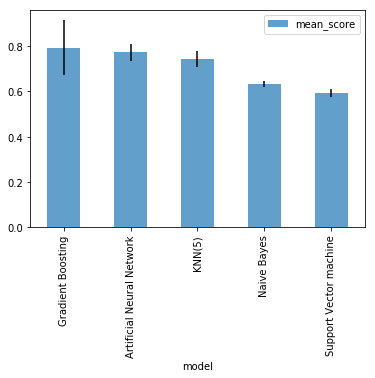

In [472]:
df_model_scores = []
for desc, scores in cross_val_scores:
    d = {
        'model':desc,
        'mean_score':np.mean(scores),
        'std_score':np.std(scores)
    }
    df_model_scores.append(d)
df_model_scores = pd.DataFrame(df_model_scores).set_index('model')

df_model_scores.sort_values(by = 'mean_score', ascending = False).plot(
    kind = 'bar',yerr='std_score', alpha = 0.7)

## Cost analysis

Suppose the labels are:

* TP -- correctly identifying a student who will NOT return;
* FP -- the model marks a returning student as 'non-return';
* TN -- correctly identifying a student who WILL return;
* FN -- missing a student who will NOT return;

Suppose the cost of intervening action is 1,000 and every student brings 30,000 to the university. Then the costs of errors are as follows:

* TP -- +30,000-1,0000 = 29000
* FP -- -1,000
* TN -- 0
* FN -- -30,000

In [486]:
error_costs = np.array([29000,-1000,0,-30000])
desc, m = models[0]
funds_saved = []

for desc, m in models:
    m.fit(X_train_smote,y_train_smote)
    y_hat = m.predict(X_test)
    TP = np.sum((y_hat == y_test) & (y_test == 0))
    FP = np.sum((y_hat != y_test) & (y_test == 1))
    TN = np.sum((y_hat == y_test) & (y_test == 1))
    FN = np.sum((y_hat != y_test) & (y_test == 0))
    funds_saved.append((desc,np.dot(np.array([TP,FP,TN,FN]),error_costs)))

In [488]:
sorted(funds_saved,key = lambda x:-x[1])

[('Support Vector machine', 5159000),
 ('Naive Bayes', 4942000),
 ('Gradient Boosting', 864000),
 ('Artificial Neural Network', -1591000),
 ('KNN(5)', -5929000)]

Considering the above artificial figures, the university can save approximately $5M when applying a Support Vector Machine or Naive Bayes models on the test subset of students including 923 students.

# Conclusion

In summary, despite relatively poor performance of the models, at least several of them (Support Vector machine and Naive Bayes) can be used in practice. 

Further improvements are possible by:

* Using more data:
    * More students;
    * More information about each student, such as their demographics, performance at classes taken, etc.
* Applying other strategies for feature selection, creating features, cleaning data, and imputing missing values;
* Fine tuning machine learning algorithms;